In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.optim as optim

from utils import load_data,normalize,toy_data,norm_embed,nmi_score

import matplotlib.pyplot as plt 

from sklearn.utils import shuffle

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from layers import GraphConvolution, InnerProduct
from utils import norm_embed
import torch

In [3]:
class GNN(nn.Module):
    
    def __init__(self, batch_size, nfeat, nhid, ndim, mu0, sigma0, fixed):
        super(GNN, self).__init__()

        self.gc1 = GraphConvolution(batch_size, nfeat, nhid, mu0, sigma0, scale=False)
        self.fixed = fixed
        if self.fixed:
            self.embeddings = GraphConvolution(batch_size, nhid, 2*ndim, mu0, sigma0, scale=True)
            self.reconstructions = InnerProduct(2*ndim)
        else:
            self.embeddings = GraphConvolution(batch_size, nhid, 4 * ndim, mu0, sigma0, scale=True)
            self.reconstructions = InnerProduct(4*ndim)
        

    def forward(self, x, adj):
        x = self.gc1(x, adj)
        #x = self.embeddings(x, adj)
        #x = norm_embed(x)
        if self.fixed:
            mu = F.relu(self.reconstructions(x))
            return mu
        else:
            lr1, lr2 = torch.chunk(x, chunks=2, dim=2)
            mu = F.relu(self.reconstructions(lr1))
            sigma = F.relu(self.reconstructions(lr2))
            return mu, sigma
    

In [4]:
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False,precision=8)

In [5]:
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=426, help='Random seed.')
parser.add_argument('--epochs', type=int, default=20001,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.0000001,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=10e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--ndim', type=int, default=2,
                    help='Embeddings dimension.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [6]:
if 1:
    # Taxi Dataset Graph
    adj = load_data()
    #adj = load_data(daily=True)
else:
    #Toy Example Graph
    adj = toy_data()

In [7]:
def svdApprox(adj,dim,relu=False):
    adj = torch.FloatTensor(adj[0])
    U, S, Vh = torch.linalg.svd(adj)
    mu = torch.matmul(torch.matmul(U[:, :dim], torch.diag(S[:dim])), Vh[:dim, :])
    
    embedx = torch.matmul(U[:, :dim],torch.diag(torch.pow(S[:dim], 0.5)))
    embedy = torch.transpose(torch.matmul(torch.diag(torch.pow(S[:dim], 0.5)),Vh[:dim, :]),0,1)
    
    criterion = torch.nn.GaussianNLLLoss()
    if relu:
        crt = torch.nn.ReLU()
        mu = crt(mu)
    mse = torch.nn.MSELoss()
    mseloss = mse(torch.flatten(mu), torch.flatten(adj))
    sig = torch.sqrt(mseloss)
    sigma = sig * torch.ones(adj.shape)
    loss = criterion(torch.flatten(adj), torch.flatten(mu), torch.flatten(torch.square(sigma)))
    
    return mu,sigma,loss.item(),embedx,embedy

In [8]:
def GraphNeuralNet(adj,dim,fixed=False):
    
    # Set the random seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
        
    args.ndim = dim
    
    adj_norm = normalize(adj)

    adj = torch.FloatTensor(np.array(adj))
    
    # loss function
    criterion = torch.nn.GaussianNLLLoss()
    
    
    #features = torch.FloatTensor(torch.eye(adj.shape[1]))
    #features = features.reshape((1,adj.shape[1],adj.shape[1]))
    #features = features.repeat(adj.shape[0], 1, 1)
    
    # NULL Model
    mu0 = adj.mean()*torch.ones(adj.shape[1:])
    sigma0 = adj.std()*torch.ones(adj.shape[1:])
    with torch.no_grad():
        loss0 = criterion(torch.flatten(adj), torch.flatten(mu0), torch.flatten(torch.square(sigma0)))
    
    #svd features
    svd_mu,svd_sig,svd_loss,svdembedx,svdembedy = svdApprox(adj=adj,dim=dim)
    features = torch.cat((svdembedx,svdembedy),dim=1)
    if not fixed:
        mse = torch.nn.MSELoss()
        mseloss = mse(torch.flatten(svd_mu),torch.flatten(adj))
        sig = torch.sqrt(mseloss)/dim
        svd_sig = torch.ones(features.shape)*torch.sqrt(sig)
        features = torch.cat((features,svd_sig),dim=1)
    features = features.unsqueeze(dim=0)
    #with torch.no_grad():
        #svd_loss = criterion(torch.flatten(adj), torch.flatten(svd_mu), torch.flatten(torch.square(svd_sig)))
        #print(svd_loss)
    
    

    # Model and optimizer
    """model = GNN(batch_size=adj.shape[0],
                nfeat=features.shape[2],
                nhid=args.hidden*args.ndim,
                ndim=args.ndim,
                mu0=adj.mean(),
                sigma0=adj.std(),
                fixed=fixed)
"""
    
        
        
    model = GNN(batch_size=adj.shape[0],
                nfeat=adj.shape[1],
                nhid=adj.shape[1],
                ndim=args.ndim,
                mu0=adj.mean(),
                sigma0=adj.std(),
                fixed=fixed)
    
    
    """activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.embeddings.register_forward_hook(get_activation('embeddings'))"""
    

    if args.cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()


    # Train model
    t_total = time.time()
    
    # NULL Model
    mu0 = adj.mean()*torch.ones(adj.shape[1:])
    sigma0 = adj.std()*torch.ones(adj.shape[1:])
    with torch.no_grad():
        loss0 = criterion(torch.flatten(adj), torch.flatten(mu0), torch.flatten(torch.square(sigma0)))

    optimizer = optim.Adam(model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)
    
    

    for epoch in range(args.epochs):

        t = time.time()
        model.train()
        optimizer.zero_grad()
        
        
        #adj[0],features[0] = shuffle(adj[0],features[0]) # batch number
        
        
        if fixed:
            mu = model(features, adj_norm)
            with torch.no_grad():
                mse = torch.nn.MSELoss()
                mseloss = mse(torch.flatten(mu),torch.flatten(adj))
                sig = torch.sqrt(mseloss)
            sigma = sig * torch.ones(adj.shape,requires_grad=True)
        else:
            mu,sigma = model(features, adj_norm)
        
        
        loss = criterion(torch.flatten(adj), torch.flatten(mu), torch.flatten(torch.square(sigma))) 
        loss.backward()
        optimizer.step()

        if epoch == 0:
            best_loss = loss
        else:
            if loss < best_loss:
                best_loss = loss

        if epoch % 5000 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss: {:.8f}'.format(best_loss.item()))
            

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    
    return mu,best_loss.item(),loss0


In [9]:
fix_loss = []
nonfix_loss = []
svd_loss = []
svdrelu_loss = []
nmi_fix = []
nmi_nonfix = []
nmi_svd = []
nmi_svdrelu = []
dims = [x for x in range(264,270)]
for dim in dims:
    print("Fixed Sigma dim {}".format(dim))
    mu,loss,loss0 = GraphNeuralNet(adj=adj,dim=dim,fixed=True)
    fix_loss.append(loss)
    nmi_fix.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))
    print("Flexible Sigma dim {}".format(dim))
    mu,loss,loss0 = GraphNeuralNet(adj=adj,dim=dim)
    nonfix_loss.append(loss)
    nmi_nonfix.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))
    mu,sig,loss,embedx,embedy = svdApprox(adj=adj,dim=dim)
    svd_loss.append(loss)
    nmi_svd.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))
    mu,sig,loss,embedx,embedy = svdApprox(adj=adj,dim=dim,relu=True)
    svdrelu_loss.append(loss)
    nmi_svdrelu.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))

Fixed Sigma dim 264
Epoch: 0001 loss: -2.16319942
Epoch: 5001 loss: -2.30668902
Epoch: 10001 loss: -2.31101966
Epoch: 15001 loss: -2.34482002
Epoch: 20001 loss: -2.35187578
Optimization Finished!
Total time elapsed: 71.8987s
Flexible Sigma dim 264
Epoch: 0001 loss: -2.15404558
Epoch: 5001 loss: -2.26086235
Epoch: 10001 loss: -2.26086235
Epoch: 15001 loss: -2.26086235
Epoch: 20001 loss: -2.26086235
Optimization Finished!
Total time elapsed: 100.7693s
Fixed Sigma dim 265
Epoch: 0001 loss: -2.16338563
Epoch: 5001 loss: -2.32835650
Epoch: 10001 loss: -2.32835650
Epoch: 15001 loss: -2.32835650
Epoch: 20001 loss: -2.32835650
Optimization Finished!
Total time elapsed: 71.5488s
Flexible Sigma dim 265
Epoch: 0001 loss: -2.15420961
Epoch: 5001 loss: -2.27956557
Epoch: 10001 loss: -2.28386974
Epoch: 15001 loss: -2.28386974
Epoch: 20001 loss: -2.28386974
Optimization Finished!
Total time elapsed: 101.6607s
Fixed Sigma dim 266
Epoch: 0001 loss: -2.16338563
Epoch: 5001 loss: -2.32835650
Epoch: 10001

NMI Score
Dim	 Nonfix	 Fix	 SVDRel	 SVD
264	 0.9836	 0.9907	 1.0000	 1.0000
265	 0.9836	 0.9907	 0.9809	 0.9809
266	 0.9836	 0.9907	 1.0000	 1.0000
267	 0.9644	 0.9907	 0.9660	 1.0000
268	 0.9836	 0.9907	 0.9820	 0.9809
269	 0.9643	 0.9907	 0.9809	 1.0000

 NLL0 = 11.34196949005127


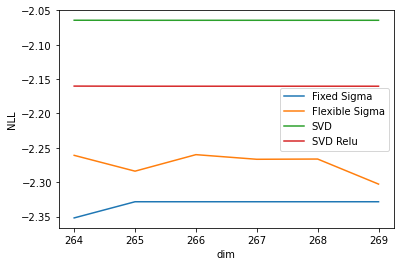

In [10]:
plt.plot(dims,fix_loss,label="Fixed Sigma")
plt.plot(dims,nonfix_loss,label="Flexible Sigma")
plt.plot(dims,svd_loss,label="SVD")
plt.plot(dims,svdrelu_loss,label="SVD Relu")
plt.xlabel("dim")
plt.ylabel("NLL")
plt.legend()
print("NMI Score")
print("{}\t {}\t {}\t {}\t {}".format("Dim","Nonfix","Fix","SVDRel","SVD"))
for i in range(len(dims)):
    print("{}\t {:.4f}\t {:.4f}\t {:.4f}\t {:.4f}".format(dims[i],nmi_nonfix[i-1],nmi_fix[i-1],nmi_svdrelu[i-1],nmi_svd[i-1]))
print("\n NLL0 = {}".format(loss0))

Text(0, 0.5, 'NLL')

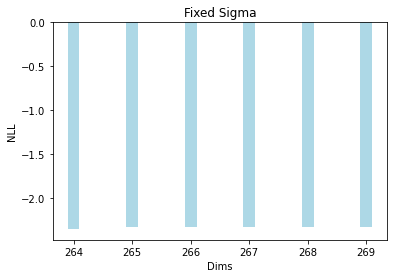

In [11]:
plt.bar(dims,fix_loss,color ='lightblue',width = 0.2)
plt.title("Fixed Sigma")
plt.xlabel("Dims")
plt.ylabel("NLL")

Text(0, 0.5, 'NLL')

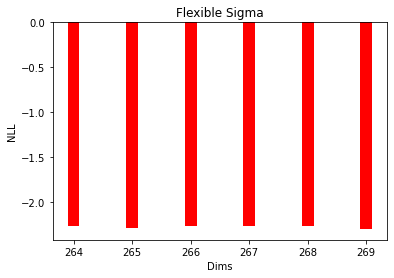

In [12]:
plt.bar(dims,nonfix_loss,color ='red',width = 0.2)
plt.title("Flexible Sigma")
plt.xlabel("Dims")
plt.ylabel("NLL")